In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import line_profiler

import datetime

from io import StringIO
from pandas.api.types import CategoricalDtype

import pandas._testing as tm

## returns df from string data
def g(data):
    return pd.read_csv(StringIO(data))

In [155]:
df_merged

,ID,March_Number,March_Amount,Feb_Number,Feb_Amount,Jan_Number,Jan_Amount
0,A,10.0,200.0,1.0,0.0,6.0,800.0
1,B,4.0,300.0,8.0,500.0,1.0,50.0
2,C,2.0,100.0,NaN,NaN,NaN,NaN
3,E,NaN,NaN,4.0,400.0,NaN,NaN
4,F,NaN,NaN,8.0,0.0,NaN,NaN
5,H,NaN,NaN,4.0,200.0,3.0,500.0
6,G,NaN,NaN,NaN,NaN,8.0,100.0


In [159]:
from threading import Thread

def foo(bar):
    return 'foo'

thread = Thread(target=foo, args=('world!',))
thread.start()
ret = thread.join()
print (ret)

None


In [163]:
import concurrent.futures

def foo(bar):
    print('hello {}'.format(bar))
    return 'foo'

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    future = executor.submit(foo, 'world!')
    return_value = future.result()
    print(return_value)

hello world!
foo


In [171]:
import yfinance as yf
df = yf.download(tickers='AAPL', start='2019-01-01', end='2021-01-01', period=max, interval='1d')

AttributeError: module 'yfinance' has no attribute 'download'

In [176]:
d = {'Name1':['jaap','piet','tim'],'Name2':['bas','max','piet'], 'Count1':[1,5,2],'Count2' :[2,6,8]}

data = pd.DataFrame(d)
data

,Name1,Name2,Count1,Count2
0,jaap,bas,1,2
1,piet,max,5,6
2,tim,piet,2,8


In [177]:
data.groupby(['Name1','Count1']).sample()

,Name1,Name2,Count1,Count2
0,jaap,bas,1,2
1,piet,max,5,6
2,tim,piet,2,8


In [178]:
d="""ID,Value1,Value2    
ID_1,NaN,2  
ID_2,NaN,7    
ID_1,5,NaN   
ID_2,8,NaN"""
df=g(d)
df

,ID,Value1,Value2
0,ID_1,NaN,2
1,ID_2,NaN,7
2,ID_1,5.0,NaN
3,ID_2,8.0,NaN


In [19]:
df=DataFrame({
    'No Show (%)':[5e-01, 4e-01, np.nan]
})
df

,No Show (%)
0,0.5
1,0.4
2,NaN


In [20]:
df['No Show (%)'] = df['No Show (%)'].transform(lambda x: '{:,.2%}'.format(x))
df

,No Show (%)
0,50.00%
1,40.00%
2,nan%


<AxesSubplot:>

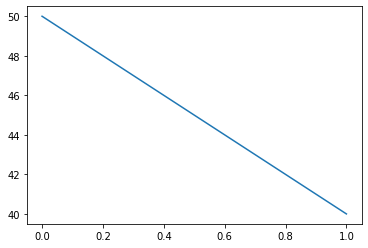

In [21]:
df['No Show (%)'].replace('\%','', regex=True).astype(float).plot()

In [22]:
df = pd.DataFrame({'A':np.arange(1.0,9.0)},index=pd.date_range(start='2020-05-04 08:00:00', freq='1d', periods=8))
df

,A
2020-05-04 08:00:00,1.0
2020-05-05 08:00:00,2.0
2020-05-06 08:00:00,3.0
2020-05-07 08:00:00,4.0
2020-05-08 08:00:00,5.0
2020-05-09 08:00:00,6.0
2020-05-10 08:00:00,7.0
2020-05-11 08:00:00,8.0


In [23]:
ref_date = '2020-05-08'

In [24]:
df['Condi'] = np.where(df.index < ref_date, 'Before', 'After')
df

,A,Condi
2020-05-04 08:00:00,1.0,Before
2020-05-05 08:00:00,2.0,Before
2020-05-06 08:00:00,3.0,Before
2020-05-07 08:00:00,4.0,Before
2020-05-08 08:00:00,5.0,After
2020-05-09 08:00:00,6.0,After
2020-05-10 08:00:00,7.0,After
2020-05-11 08:00:00,8.0,After


In [26]:
df

AttributeError: module 'yfinance' has no attribute 'Ticker'

In [28]:
df

,ID,group,attempts,successes,score
0,1,A,0,1,None
1,1,A,1,0,5
2,1,A,1,0,5
3,1,A,1,0,4
4,2,A,1,0,5
5,2,A,1,0,4
6,3,A,1,0,5
7,3,A,0,1,None
8,3,A,1,0,1
9,4,B,1,0,5


In [32]:
df.loc[df.ID == 5]

,ID,group,attempts,successes,score


In [36]:
df = pd.DataFrame({'day': ['1', '21', '41', '61', '81', '101', '121', '141',
                           '161', '181', '201', '221'],
                   'Sale': [1.08, 0.9, 0.72, 0.58, 0.48, 0.42, 0.37, 0.33, 0.26,
                            0.24, 0.22, 0.11]})
# Generate Some new values
to_add = pd.DataFrame({'day': np.arange(241, 301, 20)})

# Add New Values To End of DataFrame
new_df = pd.concat((df, to_add)).reset_index(drop=True)
new_df

new_df['Sale'] = np.where(new_df['Sale'].isna(),
                          new_df['Sale'].expanding().mean(),
                          new_df['Sale'])
new_df

,day,Sale
0,1,1.080000
1,21,0.900000
2,41,0.720000
3,61,0.580000
4,81,0.480000
5,101,0.420000
6,121,0.370000
7,141,0.330000
8,161,0.260000
9,181,0.240000


In [38]:
d="""X1,X2_nan,x3,x4_nan
34,0,65.8,1
35,1,5432.1,1
87,1,443.1,0
65,0,213.3,0"""
df=g(d)
df

,X1,X2_nan,x3,x4_nan
0,34,0,65.8,1
1,35,1,5432.1,1
2,87,1,443.1,0
3,65,0,213.3,0


In [42]:
df.filter(like='nan')

ValueError: Boolean array expected for the condition, not int64

In [57]:
d="""date,name,number
2021-05-06T07:35:03.000Z,mark,123
2021-04-06T07:35:03.000Z,mark,123
2021-03-03T07:35:03.000Z,mark,123
2021-02-03T07:35:03.000Z,mark,123
2021-05-06T07:35:03.000Z,tom,4123
2021-04-06T07:35:03.000Z,tom,4123
2021-03-03T07:35:03.000Z,tom,4123
2021-02-06T07:35:03.000Z,john,512
2021-02-06T07:35:03.000Z,wood,512
2021-02-06T07:35:03.000Z,wood,512
2020-05-06T07:35:03.000Z,paul,723
2020-04-06T07:35:03.000Z,paul,723
2020-03-03T07:35:03.000Z,paul,723
2020-02-03T07:35:03.000Z,paul,723
2020-02-03T05:35:03.000Z,paul,723
2020-02-02T07:35:03.000Z,paul,723
2020-02-01T07:35:03.000Z,paul,723
2020-05-06T07:35:03.000Z,tomy,623
2020-04-06T07:35:03.000Z,tomy,623
2020-03-03T07:35:03.000Z,tomy,623
2020-02-03T07:35:03.000Z,tomy,623
2020-02-03T05:35:03.000Z,tomy,623
2020-02-02T07:35:03.000Z,tomy,623"""
df=g(d)
df

,date,name,number
0,2021-05-06T07:35:03.000Z,mark,123
1,2021-04-06T07:35:03.000Z,mark,123
2,2021-03-03T07:35:03.000Z,mark,123
3,2021-02-03T07:35:03.000Z,mark,123
4,2021-05-06T07:35:03.000Z,tom,4123
5,2021-04-06T07:35:03.000Z,tom,4123
6,2021-03-03T07:35:03.000Z,tom,4123
7,2021-02-06T07:35:03.000Z,john,512
8,2021-02-06T07:35:03.000Z,wood,512
9,2021-02-06T07:35:03.000Z,wood,512


In [58]:
%timeit np.where(df.groupby('name').cumcount().ge(3), 'old_employee', '')

1.76 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [59]:
%timeit df.loc[df.groupby('name').cumcount() >= 3, 'status'] = 'old_employee'

2.29 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
